In [1]:
# pakiety
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import permutation_test
from scipy.stats import chi2_contingency

In [2]:
# Zmienne i ustawienia globalne
sns.set_style("whitegrid")
sns.set_palette("Set2") 
DATA_PATH = "titanic.txt"

In [3]:
# Funkcje
def plot_null_vs_full(*args):
    """
    Rysuje histogramy dla grup "null" i "full" dla każdej pary kolumn przekazanej jako argument.
    
    Args:
        *args: dowolna liczba krotek (col_null, col_full)
        
    Returns:
        None (wyświetla wykres)
    """
    n_cols = len(args)
    fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 5))

    if n_cols == 1:
        axes = [axes]

    for i, (col_null, col_full) in enumerate(args):
        ax = axes[i]

        sns.histplot(
            col_null,
            color='red',
            alpha=0.5,
            stat='probability',
            label='Null group',
            ax=ax
        )

        sns.histplot(
            col_full,
            color='blue',
            alpha=0.5,
            stat='probability',
            label='Full data',
            ax=ax
        )

        ax.set_title('Distribution')
        ax.legend()

    plt.tight_layout()
    plt.show()


def permutation_tests_nan(df, compare_col):
    """
    Wykonuje testy permutacyjne dla kolumn zależnych od braków danych w wybranej kolumnie.
    
    Args:
        df (pd.DataFrame): DataFrame z danymi
        compare_col (str): Nazwa kolumny, w której sprawdzamy brakujące wartości (NaN)
        
    Returns:
        pd.DataFrame: DataFrame z wartościami p dla każdej kolumny testowanej
    """
    cols = ['pclass', 'sex', 'sibsp', 'parch', 'embarked', 'titles', 'family']
    index_names = [
        'Klasa biletu',
        'Płeć',
        'Rodzeństwo/Małżonka/Małżonek',
        'Rodzice/Dzieci',
        'Port wypłynięcia',
        'Tytuł',
        'Wielkość rodziny na statku'
    ]

    results = []
    for col in cols:
        res = permutation_test(
            (df.loc[df[compare_col].isna(), col], df.loc[df[compare_col].notna(), col]),
            statistic=lambda x, y: np.mean(x) - np.mean(y),
            vectorized=False,
            n_resamples=10000,
            alternative='two-sided',
            permutation_type='independent'
        )
        results.append(res.pvalue)

    return pd.DataFrame(results, index=index_names, columns=['pvalue'])


# Krok 1: Wczytywanie danych

W tej sekcji wczytujemy dane z pliku `titanic.txt`, zamieniamy brakujące wartości oznaczone jako `"?"` na `NaN` i nadajemy kolumnom czytelne nazwy. Dodatkowo konwertujemy kolumny `age` i `fare` na typ liczbowy.

In [4]:
# Wczytanie danych
df = pd.read_csv(DATA_PATH)

# Zamiana "?" na NaN
df = df.replace("?", np.nan)

# Poprawa nazw kolumn
df.columns = [
    'pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch',
    'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'
]

# Zmiana na liczby
df['age'] = df['age'].astype(float)
df['fare'] = df['fare'].astype(float)

df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Krok 2: Eksploracja danych

## Znaczenie kolumn
- `pclass` – klasa biletu  
- `survived` – czy przeżył (0 – zginął, 1 – przeżył)  
- `name` – nazwisko i imię  
- `sex` – płeć  
- `age` – wiek  
- `sibsp` – liczba rodzeństwa / małżonków  
- `parch` – liczba rodziców / dzieci  
- `ticket` – numer biletu  
- `fare` – cena biletu  
- `cabin` – numer kabiny pasażera  
- `embarked` – port, z którego wypłynął pasażer  
- `boat` – numer łodzi ratunkowej
- `body` – numer ciała
- `home.dest` – miejsce zamieszkania

## Zamiana danych ilościowych na jakościowe
W tej sekcji planujemy przekształcenie danych w bardziej użyteczne zmienne jakościowe:

1. **Pokład z kabiny (`cabin`)** – usunięcie cyfr i pozostawienie jedynie litery oznaczającej pokład.  
2. **Tytuły z imienia (`name`)** – wydzielenie przedrostków typu 'Miss', 'Mr', 'Mrs' itp., które mogą pomóc w estymacji wieku przy brakach danych.  
   - Mapowanie: `'Miss': 0, 'Master': 1, 'Mr': 2, 'Mrs': 3, 'Col': 4, 'Mme': 5, 'Dr': 6, 'Major': 7, 'Capt': 8, 'Lady': 9, 'Sir': 10, 'Mlle': 11, 'Dona': 12, 'Jonkheer': 13, 'the Countess': 14, 'Don': 15, 'Rev': 16, 'Ms': 17`  
3. **Grupa wiekowa (`age_group`)** – podział wieku na kategorie, które mogą być bardziej przydatne niż surowy wiek.  
4. **Wielkość rodziny (`family_size`)** – suma `sibsp` i `parch` + 1.  
5. **Płeć (`sex`)** – zamiana na zmienną binarną (0 – mężczyzna, 1 – kobieta).  
6. **Port wypłynięcia (`embarked`)** – zamiana na zmienną liczbową (0 – C, 1 – Q, 2 – S).  


In [5]:
df['cabin'] = df['cabin'].astype(object).str[0]
df['name'] = df['name'].astype(str)

# Wydzielenie tytułów z kolumny 'name'
df['titles'] = df['name'].str.extract(r',\s*([^\.]+)\.')

title_map = {
    'Miss': 0, 'Master': 1, 'Mr': 2, 'Mrs': 3, 'Col': 4, 'Mme': 5, 'Dr': 6,
    'Major': 7, 'Capt': 8, 'Lady': 9, 'Sir': 10, 'Mlle': 11, 'Dona': 12,
    'Jonkheer': 13, 'the Countess': 14, 'Don': 15, 'Rev': 16, 'Ms': 17
}
df['titles'] = df['titles'].map(title_map)

# Utworzenie grup wiekowych
df['age_group'] = pd.cut(
    df['age'],
    bins=[0, 15, 50, np.inf],
    labels=[0, 1, 2],
    right=True
)

# Wielkość rodziny
df['family'] = df['sibsp'] + df['parch'] + 1

# Zamiana płci na zmienną binarną
df['sex'] = df['sex'].astype(str).map({'male': 0, 'female': 1})

# Zamiana portu wypłynięcia na liczby
df['embarked'] = df['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,titles,age_group,family
0,1,1,"Allen, Miss. Elisabeth Walton",1,29.0000,0,0,24160,211.3375,B,2.0,2,NaN,"St Louis, MO",0,1,1
1,1,1,"Allison, Master. Hudson Trevor",0,0.9167,1,2,113781,151.5500,C,2.0,11,NaN,"Montreal, PQ / Chesterville, ON",1,0,4
2,1,0,"Allison, Miss. Helen Loraine",1,2.0000,1,2,113781,151.5500,C,2.0,NaN,NaN,"Montreal, PQ / Chesterville, ON",0,0,4
3,1,0,"Allison, Mr. Hudson Joshua Creighton",0,30.0000,1,2,113781,151.5500,C,2.0,NaN,135,"Montreal, PQ / Chesterville, ON",2,1,4
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,25.0000,1,2,113781,151.5500,C,2.0,NaN,NaN,"Montreal, PQ / Chesterville, ON",3,1,4


# Krok 3: Sprawdzenie ilości braków danych
W tej sekcji sprawdzimy, ile brakujących wartości (`NaN`) występuje w każdej kolumnie.

In [27]:
# Tworzenie statystyk braków danych
df_stats = pd.DataFrame(
    [
        df.isna().sum(),
        round(df.isna().mean() * 100, 2)
    ],
    index=["Ilość NaN", "Średni odsetek brakujących danych [%]"]
)

# Zachowanie tylko kolumn z brakami danych
df_stats = df_stats.loc[:, (df_stats != 0).any(axis=0)]

# Sortowanie według ilości braków
df_stats.sort_values("Ilość NaN", axis=1)


,fare,embarked,age,age_group,home.dest,boat,cabin,body
Ilość NaN,1.00,2.00,263.00,263.00,564.00,823.00,1014.00,1188.00
Średni odsetek brakujących danych [%],0.08,0.15,20.09,20.09,43.09,62.87,77.46,90.76


Od razu widać, że w kolumnie `fare` i `embarked` są pojedyncze wartości NaN 
(odpowiednio 1 i 2), więc błędy te są definitywnie **MCAR**.

# Krok 4: Wykorzystanie wiedzy eksperckiej

Wiedząc, że `body` to numer wyłowionego ciała, a `boat` to numer łodzi ratunkowej, 
w której pasażer opuszczał pokład, można od razu założyć, że te kolumny są powiązane z przeżyciem.

In [28]:
# Podział danych na zmarłych i ocalonych
df_dead = df[df['survived'] == 0]
df_live = df[df['survived'] == 1]

# Statystyki braków danych dla każdej grupy
df_stats_by_survived = pd.DataFrame(
    [
        df_dead.isna().sum(),
        round(df_dead.isna().mean() * 100, 2),
        df_live.isna().sum(),
        round(df_live.isna().mean() * 100, 2)
    ],
    index=[
        'Zmarli - Ilość NaN',
        'Zmarli - Odsetek NaN [%]',
        'Ocalali - Ilość NaN',
        'Ocalali - Odsetek NaN [%]'
    ]
)

# Zachowanie tylko kolumn z brakami danych
df_stats_by_survived = df_stats_by_survived.loc[:, (df_stats_by_survived != 0).any(axis=0)]

# Usunięcie kolumn 'fare' i 'embarked'
df_stats_by_survived.drop(['fare', 'embarked'], axis=1)


,age,cabin,boat,body,home.dest,age_group
Zmarli - Ilość NaN,190.00,707.00,800.00,688.00,411.0,190.00
Zmarli - Odsetek NaN [%],23.49,87.39,98.89,85.04,50.8,23.49
Ocalali - Ilość NaN,73.00,307.00,23.00,500.00,153.0,73.00
Ocalali - Odsetek NaN [%],14.60,61.40,4.60,100.00,30.6,14.60


Żaden ocalały, co oczywiste nie ma danych wśród kolumny `body`, więc są to błędy **MNAR**.

In [8]:
# Wyświetlenie zmarłych pasażerów, którzy mieli przypisaną łódź ratunkową
df_dead[df_dead['boat'].notna()]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,titles,age_group,family
19,1,0,"Beattie, Mr. Thomson",0,36.0,0,0,13050,75.2417,C,0.0,A,NaN,"Winnipeg, MN",2,1,1
166,1,0,"Hoyt, Mr. William Fisher",0,NaN,0,0,PC 17600,30.6958,NaN,0.0,14,NaN,"New York, NY",2,NaN,1
544,2,0,"Renouf, Mr. Peter Henry",0,34.0,1,0,31027,21.0000,NaN,2.0,12,NaN,"Elizabeth, NJ",2,1,2
655,3,0,"Backstrom, Mr. Karl Alfred",0,32.0,1,0,3101278,15.8500,NaN,2.0,D,NaN,"Ruotsinphytaa, Finland New York, NY",2,1,2
853,3,0,"Harmer, Mr. Abraham (David Lishin)",0,25.0,0,0,374887,7.2500,NaN,2.0,B,NaN,NaN,2,1,1
921,3,0,"Keefe, Mr. Arthur",0,NaN,0,0,323592,7.2500,NaN,2.0,A,NaN,NaN,2,NaN,1
968,3,0,"Lindell, Mr. Edvard Bengtsson",0,36.0,1,0,349910,15.5500,NaN,2.0,A,NaN,NaN,2,1,2
969,3,0,"Lindell, Mrs. Edvard Bengtsson (Elin Gerda Per...",1,30.0,1,0,349910,15.5500,NaN,2.0,A,NaN,NaN,3,1,2
1299,3,0,"Yasbeck, Mr. Antoni",0,27.0,1,0,2659,14.4542,NaN,0.0,C,NaN,NaN,2,1,2


Zmarli, którzy dostali się na szalupę ratunkową, płynęli różnymi łodziami i byli w większości dorosłymi mężczyznami.  
Poza tym trudno wskazać sensowną przyczynowość. Podejrzewam, że mogły to być osoby, które nie dostały się na szalupę na statku i mogły przebywać chwilę w wodzie, co spowodowało wychłodzenie organizmu lub osłabienie po przebyciu choroby.  

Gdyby wszyscy dostali się na tę samą szalupę, zaklasyfikowałbym brak danych jako **NMAR**, ale ponieważ są różne łodzie, są to błędy **MAR**.  

85% zmarłych nie posiada numeru ciała (`body`), ale wiedząc, że większości ciał nigdy nie znaleziono, nie widzę innej opcji niż zaklasyfikowanie tego jako **MCAR**.

# Krok 5: Wykonanie testów statystycznych

## Test niezależności

### Pomiędzy ocalałymi a zmarłymi


In [9]:
# Test chi-kwadrat dla braków danych w wybranych kolumnach w zależności od przeżycia
res_age = chi2_contingency(
    pd.crosstab(df['age'].isnull().astype(int), df['survived'])
)
res_age_group = chi2_contingency(
    pd.crosstab(df['age_group'].isnull().astype(int), df['survived'])
)
res_cabin = chi2_contingency(
    pd.crosstab(df['cabin'].isnull().astype(int), df['survived'])
)
res_dest = chi2_contingency(
    pd.crosstab(df['home.dest'].isnull().astype(int), df['survived'])
)

# Podsumowanie wartości p
pd.DataFrame(
    [
        res_age.pvalue,
        res_age_group.pvalue,
        res_cabin.pvalue,
        res_dest.pvalue
    ],
    index=["age", "age_group", "cabin", "home.dest"],
    columns=['pvalue']
)

,pvalue
age,1.295216e-04
age_group,1.295216e-04
cabin,1.649001e-27
home.dest,1.123109e-12


Z testów wynika, że niestety istnieje statystycznie istotna różnica między osobami, które przeżyły, a tymi, które zmarły.

### Pomiędzy kolumnami zawierającymi wartości NaN

In [10]:
#age

res_live_age_cabin = chi2_contingency(pd.crosstab(df_live['age'].isna(), df_live['cabin'].isna()))
res_live_age_home = chi2_contingency(pd.crosstab(df_live['age'].isna(), df_live['home.dest'].isna()))

res_dead_age_cabin = chi2_contingency(pd.crosstab(df_dead['age'].isna(), df_dead['cabin'].isna()))
res_dead_age_home = chi2_contingency(pd.crosstab(df_dead['age'].isna(), df_dead['home.dest'].isna()))

#age_group

res_live_age_cabin = chi2_contingency(pd.crosstab(df_live['age_group'].isna(), df_live['cabin'].isna()))
res_live_age_home = chi2_contingency(pd.crosstab(df_live['age_group'].isna(), df_live['home.dest'].isna()))

res_dead_age_cabin = chi2_contingency(pd.crosstab(df_dead['age_group'].isna(), df_dead['cabin'].isna()))
res_dead_age_home = chi2_contingency(pd.crosstab(df_dead['age_group'].isna(), df_dead['home.dest'].isna()))

#cabin

res_live_cabin_age = chi2_contingency(pd.crosstab(df_live['cabin'].isna(), df_live['age'].isna()))
res_live_cabin_age_group = chi2_contingency(pd.crosstab(df_live['cabin'].isna(), df_live['age_group'].isna()))
res_live_cabin_home = chi2_contingency(pd.crosstab(df_live['cabin'].isna(), df_live['home.dest'].isna()))

res_dead_cabin_age = chi2_contingency(pd.crosstab(df_dead['cabin'].isna(), df_dead['age'].isna()))
res_dead_cabin_age_group = chi2_contingency(pd.crosstab(df_dead['cabin'].isna(), df_dead['age_group'].isna()))
res_dead_cabin_home = chi2_contingency(pd.crosstab(df_dead['cabin'].isna(), df_dead['home.dest'].isna()))

#home.dest

res_live_home_age = chi2_contingency(pd.crosstab(df_live['home.dest'].isna(), df_live['age'].isna()))
res_live_home_age_group = chi2_contingency(pd.crosstab(df_live['home.dest'].isna(), df_live['age_group'].isna()))
res_live_home_cabin = chi2_contingency(pd.crosstab(df_live['home.dest'].isna(), df_live['cabin'].isna()))

res_dead_home_age = chi2_contingency(pd.crosstab(df_dead['home.dest'].isna(), df_dead['age'].isna()))
res_dead_home_age_group = chi2_contingency(pd.crosstab(df_dead['home.dest'].isna(), df_dead['age_group'].isna()))
res_dead_home_cabin = chi2_contingency(pd.crosstab(df_dead['home.dest'].isna(), df_dead['cabin'].isna()))

pd.DataFrame([res_live_age_cabin.pvalue,
              res_live_age_home.pvalue,
              res_live_age_cabin.pvalue,
              res_live_age_home.pvalue,
              res_live_cabin_age.pvalue,
              res_live_cabin_age_group.pvalue,
              res_live_cabin_home.pvalue,
              res_live_home_age.pvalue,
              res_live_home_age_group.pvalue,
              res_live_home_cabin.pvalue,
              res_dead_age_cabin.pvalue,
              res_dead_age_home.pvalue,
              res_dead_age_cabin.pvalue,
              res_dead_age_home.pvalue,
              res_dead_cabin_age.pvalue,
              res_dead_cabin_age_group.pvalue,
              res_dead_cabin_home.pvalue,
              res_dead_home_age.pvalue,
              res_dead_home_age_group.pvalue,
              res_dead_home_cabin.pvalue],
             index = ['Ocalali: Wiek-Kabina', 'Ocalali: Wiek-Miejsce Zamieszkania', 'Ocalali: Grupa Wieku-Kabina', 'Ocalali: Grupa Wieku-Miejsce Zamieszkania',
                      'Ocalali: Kabina-Wiek', 'Ocalali: Kabina-Grupa Wieku', 'Ocalali: Kabina-Miejsce Zamieszkania',
                      'Ocalali: Miejsce Zamieszkania-Wiek', 'Ocalali: Miejsce Zamieszkania-Grupa Wieku', 'Ocalali: Miejsce Zamieszkania-Kabina',
                      'Zmarli: Wiek-Kabina', 'Zmarli: Wiek-Miejsce Zamieszkania', 'Zmarli: Grupa Wieku-Kabina', 'Zmarli: Grupa Wieku-Miejsce Zamieszkania',
                      'Zmarli: Kabina-Wiek', 'Zmarli: Kabina-Grupa Wieku', 'Zmarli: Kabina-Miejsce Zamieszkania',
                      'Zmarli: Miejsce Zamieszkania-Wiek', 'Zmarli: Miejsce Zamieszkania-Grupa Wieku', 'Zmarli: Miejsce Zamieszkania-Kabina'],
             columns = ['pvalue'])

,pvalue
Ocalali: Wiek-Kabina,1.432229e-05
Ocalali: Wiek-Miejsce Zamieszkania,3.125792e-11
Ocalali: Grupa Wieku-Kabina,1.432229e-05
Ocalali: Grupa Wieku-Miejsce Zamieszkania,3.125792e-11
Ocalali: Kabina-Wiek,1.432229e-05
Ocalali: Kabina-Grupa Wieku,1.432229e-05
Ocalali: Kabina-Miejsce Zamieszkania,5.625409e-12
Ocalali: Miejsce Zamieszkania-Wiek,3.125792e-11
Ocalali: Miejsce Zamieszkania-Grupa Wieku,3.125792e-11
Ocalali: Miejsce Zamieszkania-Kabina,5.625409e-12


Wszystkie kolumny są niezależne.

## Ocalali

Najpierw wykonam testy dla `age_group`, ponieważ jest to zmienna jakościowa i powinna wykazać silniejsze związki niż surowy wiek.

### Grupa wieku


In [11]:
permutation_tests_nan(df_live, 'age_group')

,pvalue
Klasa biletu,0.000200
Płeć,0.582942
Rodzeństwo/Małżonka/Małzonek,0.026997
Rodzice/Dzieci,0.000200
Port Wypłynięcia,0.000200
Tytuł,0.054195
Wielkość rodziny na statku,0.000200


Odrzucamy hipotezę zerową (H0), że nie ma istotnej różnicy statystycznej dla rekordów z NaN,  
na rzecz hipotezy alternatywnej (H1), że taka różnica istnieje, dla następujących kolumn:

- Klasa biletu `pclass`  
- Rodzeństwo / Małżonek / Małżonka `sibsp`  
- Rodzice / Dzieci `parch`  
- Port wypłynięcia `embarked`  
- Wielkość rodziny na statku `family`

### Wiek


In [12]:
permutation_tests_nan(df_live, 'age')

,pvalue
Klasa biletu,0.000200
Płeć,0.577142
Rodzeństwo/Małżonka/Małzonek,0.029197
Rodzice/Dzieci,0.000200
Port Wypłynięcia,0.000200
Tytuł,0.044196
Wielkość rodziny na statku,0.000200


Odrzucamy hipotezę zerową (H0), że nie ma istotnej różnicy statystycznej dla rekordów z NaN,  
na rzecz hipotezy alternatywnej (H1), że taka różnica istnieje, dla następujących kolumn:

- Klasa biletu `pclass`  
- Rodzeństwo / Małżonek / Małżonka `sibsp`  
- Rodzice / Dzieci `parch`  
- Port wypłynięcia `embarked`  
- Wielkość rodziny na statku `family`

Jak widać, wartości p są nieco większe niż wcześniej, co oznacza, że test jest nieco mniej pewny swoich wyników.

### Kabina


In [13]:
permutation_tests_nan(df_live, 'cabin')

,pvalue
Klasa biletu,0.000200
Płeć,0.727327
Rodzeństwo/Małżonka/Małzonek,0.030797
Rodzice/Dzieci,0.647335
Port Wypłynięcia,0.000200
Tytuł,0.000200
Wielkość rodziny na statku,0.111389


Odrzucamy hipotezę zerową (H0), że nie ma istotnej różnicy statystycznej dla rekordów z NaN,  
na rzecz hipotezy alternatywnej (H1), że taka różnica istnieje, dla następujących kolumn:

- Klasa biletu `pclass`  
- Rodzeństwo / Małżonek / Małżonka `sibsp`  
- Port wypłynięcia `embarked`  
- Tytuł `titles`  
- Wielkość rodziny na statku `family`

### Miejsce zamieszkania


In [14]:
permutation_tests_nan(df_live, 'home.dest')

,pvalue
Klasa biletu,0.000200
Płeć,0.265973
Rodzeństwo/Małżonka/Małzonek,0.000200
Rodzice/Dzieci,0.000200
Port Wypłynięcia,0.000200
Tytuł,0.000400
Wielkość rodziny na statku,0.000200


Odrzucamy hipotezę zerową (H0), że nie ma istotnej różnicy statystycznej dla rekordów z NaN,  
na rzecz hipotezy alternatywnej (H1), że taka różnica istnieje, dla następujących kolumn:

- Klasa biletu `pclass`  
- Rodzeństwo / Małżonek / Małżonka `sibsp`  
- Rodzice / Dzieci `parch`  
- Port wypłynięcia `embarked`  
- Tytuł `titles`  
- Wielkość rodziny na statku `family`

## Zmarli

### Grupa wieku


In [15]:
permutation_tests_nan(df_dead, 'age_group')

,pvalue
Klasa biletu,0.000200
Płeć,0.874113
Rodzeństwo/Małżonka/Małzonek,0.682532
Rodzice/Dzieci,0.536746
Port Wypłynięcia,0.000200
Tytuł,0.325167
Wielkość rodziny na statku,0.967503


Odrzucamy hipotezę zerową (H0), że nie ma istotnej różnicy statystycznej dla rekordów z NaN,  
na rzecz hipotezy alternatywnej (H1), że taka różnica istnieje, dla następujących kolumn:

- Klasa biletu `pclass`  
- Port wypłynięcia `embarked`

### Wiek


In [16]:
permutation_tests_nan(df_dead, 'age')

,pvalue
Klasa biletu,0.000200
Płeć,0.876912
Rodzeństwo/Małżonka/Małzonek,0.702730
Rodzice/Dzieci,0.549345
Port Wypłynięcia,0.000200
Tytuł,0.324768
Wielkość rodziny na statku,0.965503


Odrzucamy hipotezę zerową (H0), że nie ma istotnej różnicy statystycznej dla rekordów z NaN,  
na rzecz hipotezy alternatywnej (H1), że taka różnica istnieje, dla następujących kolumn:

- Klasa biletu `pclass`  
- Port wypłynięcia `embarked`

Jak wcześniej, wartości p są nieco wyższe, co sugeruje, że test jest mniej pewny swoich wyników.

### Kabina


In [17]:
permutation_tests_nan(df_dead, 'cabin')

,pvalue
Klasa biletu,0.000200
Płeć,0.018798
Rodzeństwo/Małżonka/Małzonek,0.126987
Rodzice/Dzieci,0.865113
Port Wypłynięcia,0.000400
Tytuł,0.562144
Wielkość rodziny na statku,0.357964


Odrzucamy hipotezę zerową (H0), że nie ma istotnej różnicy statystycznej dla rekordów z NaN,  
na rzecz hipotezy alternatywnej (H1), że taka różnica istnieje, dla następujących kolumn:

- Klasa biletu `pclass`  
- Płeć `sex`  
- Port wypłynięcia `embarked`

### Miejsce zamieszkania


In [18]:
permutation_tests_nan(df_dead, 'home.dest')

,pvalue
Klasa biletu,0.000200
Płeć,0.002600
Rodzeństwo/Małżonka/Małzonek,0.692131
Rodzice/Dzieci,0.264774
Port Wypłynięcia,0.950505
Tytuł,0.000200
Wielkość rodziny na statku,0.777322


Odrzucamy hipotezę zerową (H0), że nie ma istotnej różnicy statystycznej dla rekordów z NaN,  
na rzecz hipotezy alternatywnej (H1), że taka różnica istnieje, dla następujących kolumn:

- Klasa biletu `pclass`  
- Płeć `sex`  
- Tytuł `titles`

# Krok 6: Wyświetlenie wyników dla zmiennych, w których występuje istotna różnica

Wykonane zostaną histogramy prawdopodobieństwa pokazujące miejsca największych różnic.

## Ocalali

### Grupa wieku


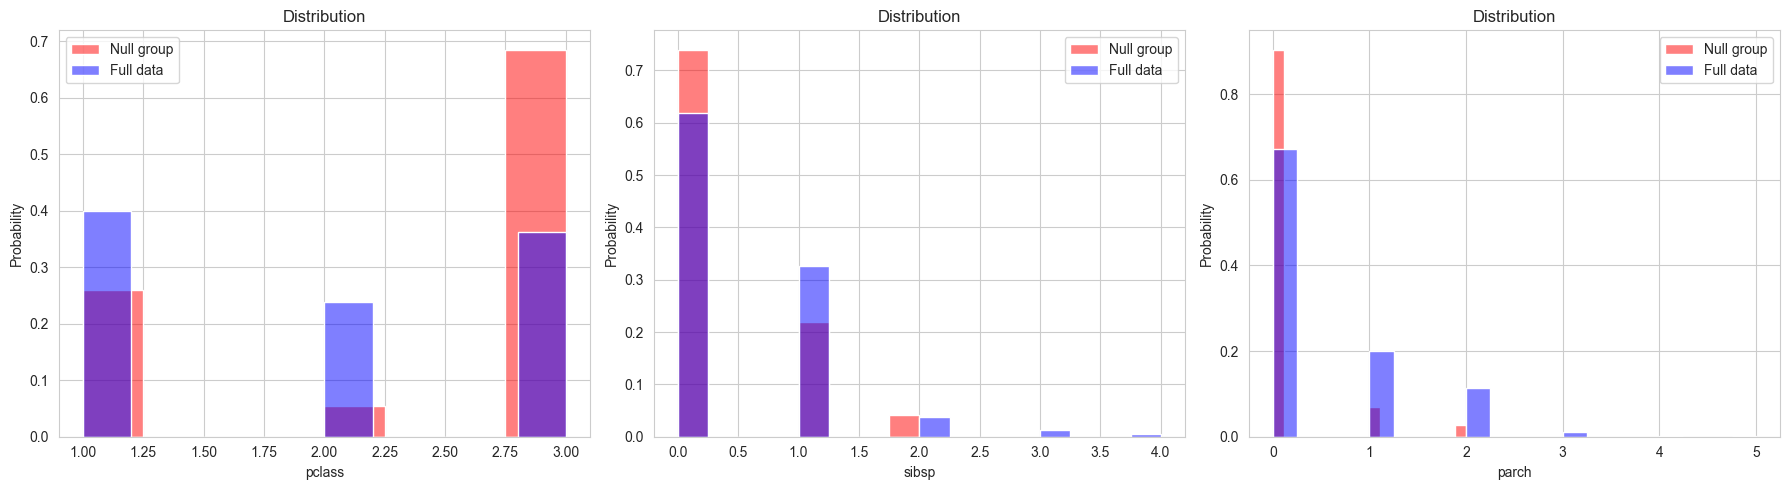

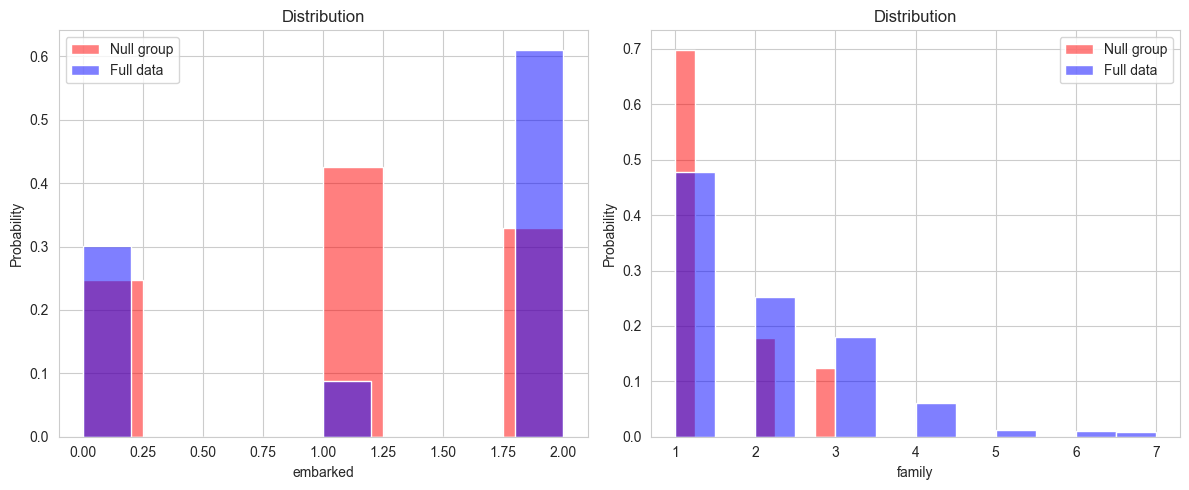

In [19]:
plot_null_vs_full(
    (df_live.loc[df_live['age_group'].isna(), 'pclass'], df_live['pclass']),
    (df_live.loc[df_live['age_group'].isna(), 'sibsp'], df_live['sibsp']),
    (df_live.loc[df_live['age_group'].isna(), 'parch'], df_live['parch'])
)
plot_null_vs_full(
    (df_live.loc[df_live['age_group'].isna(), 'embarked'], df_live['embarked']),
    (df_live.loc[df_live['age_group'].isna(), 'family'], df_live['family'])
)

### Wiek

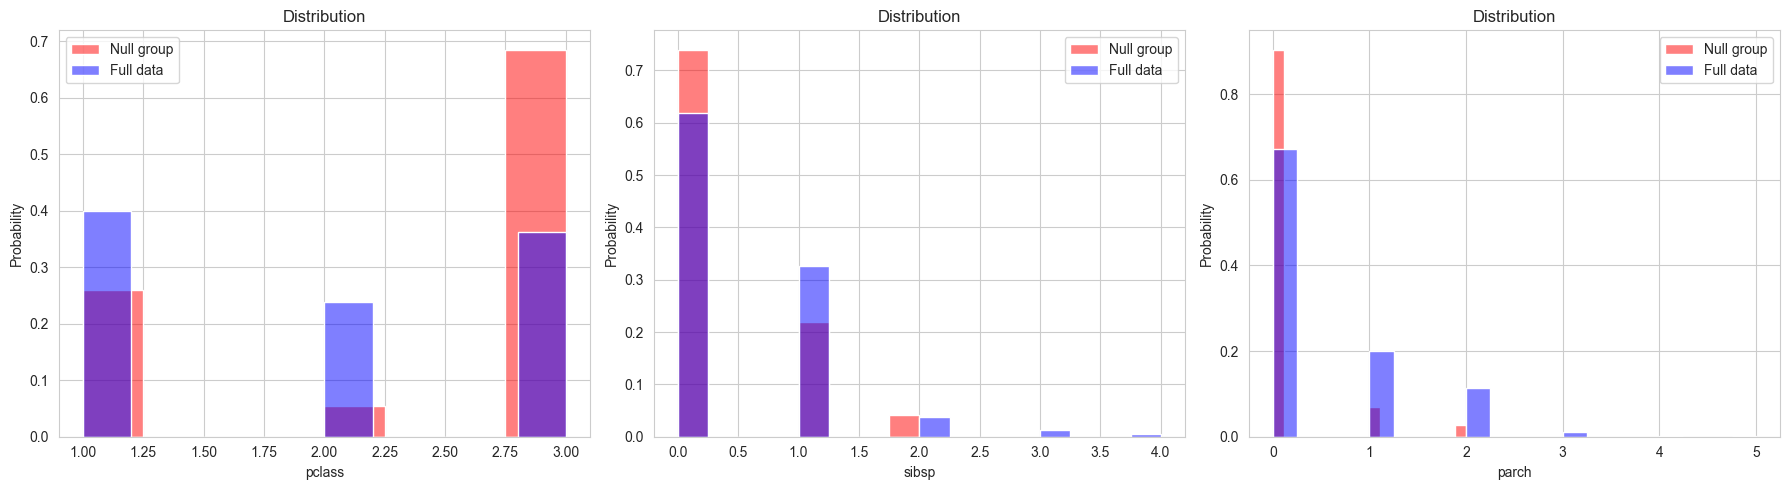

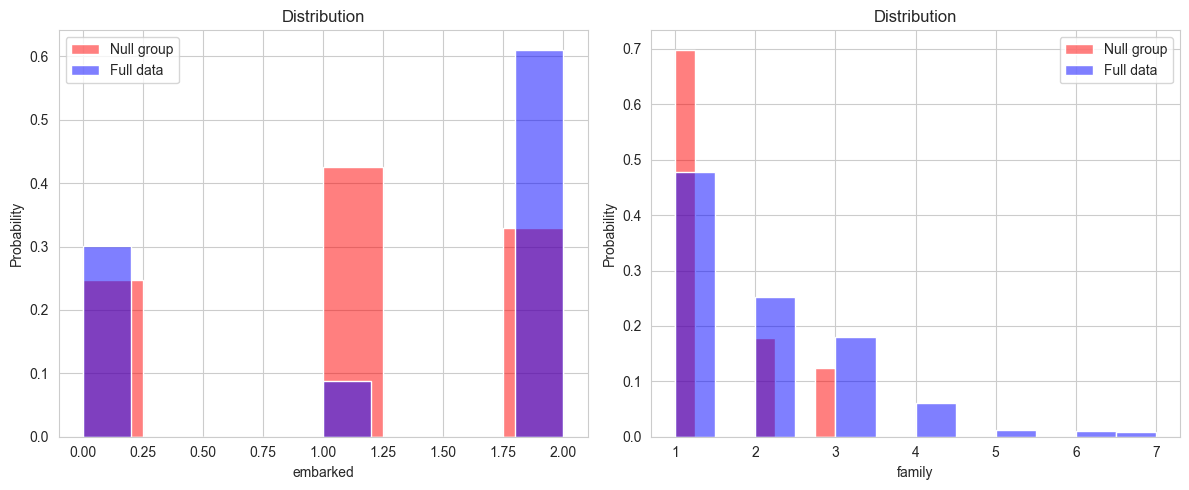

In [20]:
plot_null_vs_full(
    (df_live.loc[df_live['age'].isna(), 'pclass'], df_live['pclass']),
    (df_live.loc[df_live['age'].isna(), 'sibsp'], df_live['sibsp']),
    (df_live.loc[df_live['age'].isna(), 'parch'], df_live['parch'])
)
plot_null_vs_full(
    (df_live.loc[df_live['age'].isna(), 'embarked'], df_live['embarked']),
    (df_live.loc[df_live['age'].isna(), 'family'], df_live['family'])
)

### Kabina

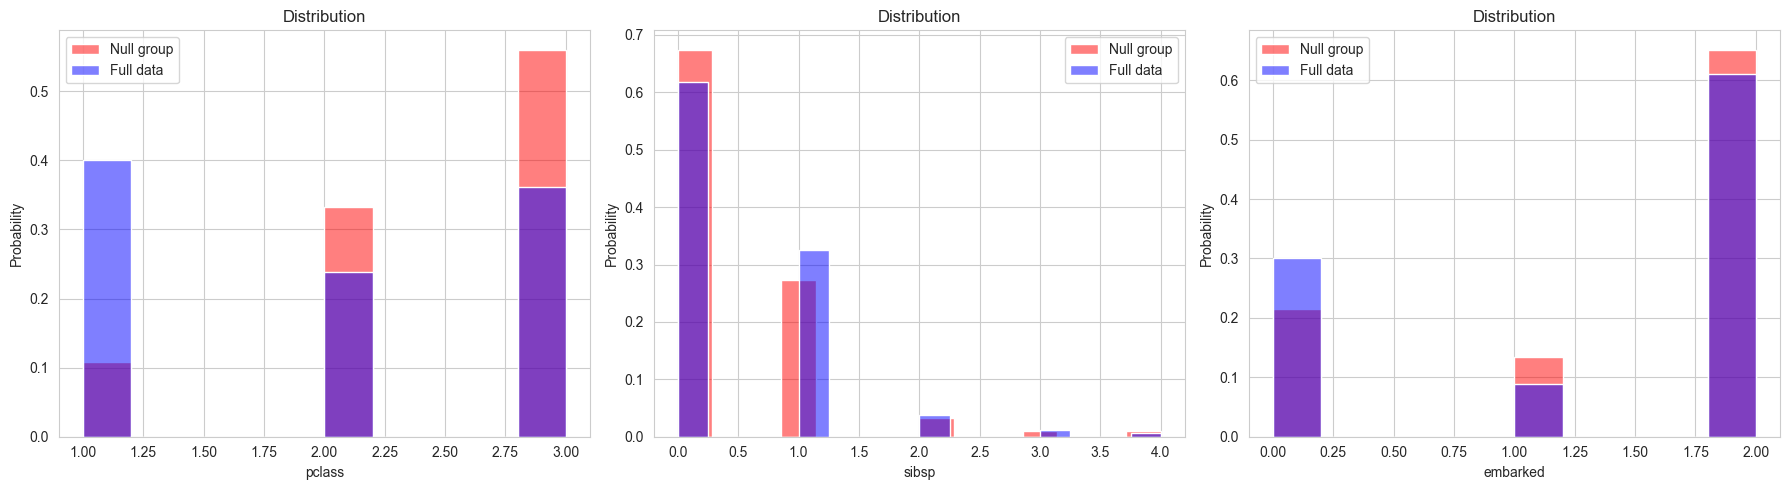

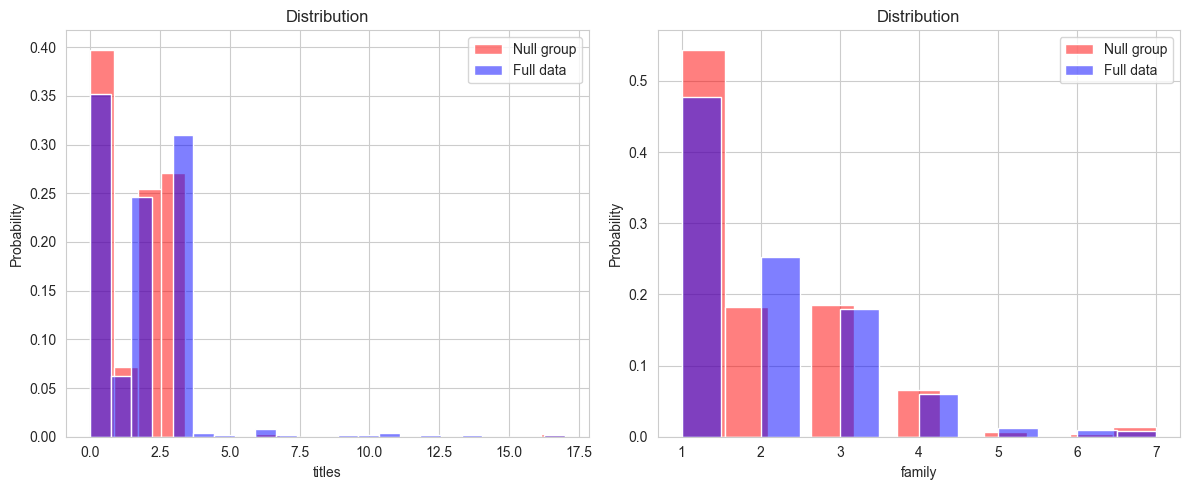

In [21]:
plot_null_vs_full(
    (df_live.loc[df_live['cabin'].isna(), 'pclass'], df_live['pclass']),
    (df_live.loc[df_live['cabin'].isna(), 'sibsp'], df_live['sibsp']),
    (df_live.loc[df_live['cabin'].isna(), 'embarked'], df_live['embarked'])
)
plot_null_vs_full(
    (df_live.loc[df_live['cabin'].isna(), 'titles'], df_live['titles']),
    (df_live.loc[df_live['cabin'].isna(), 'family'], df_live['family'])
)

### Miejsce zamieszkania

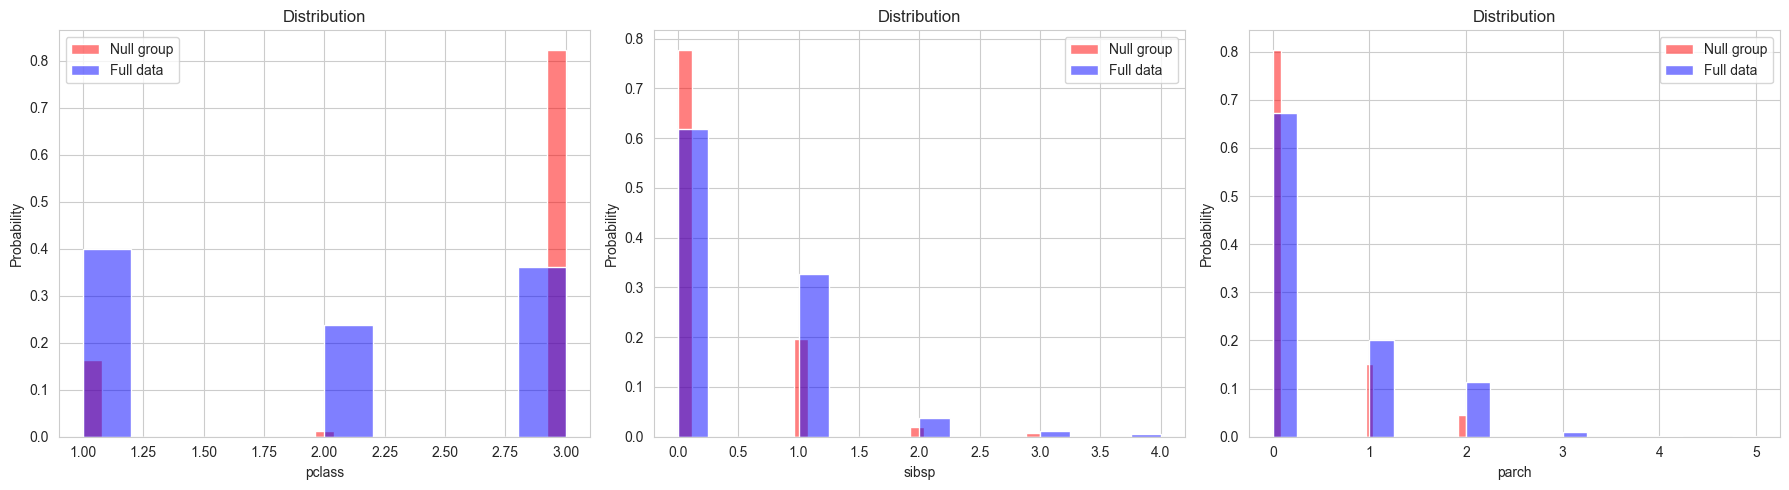

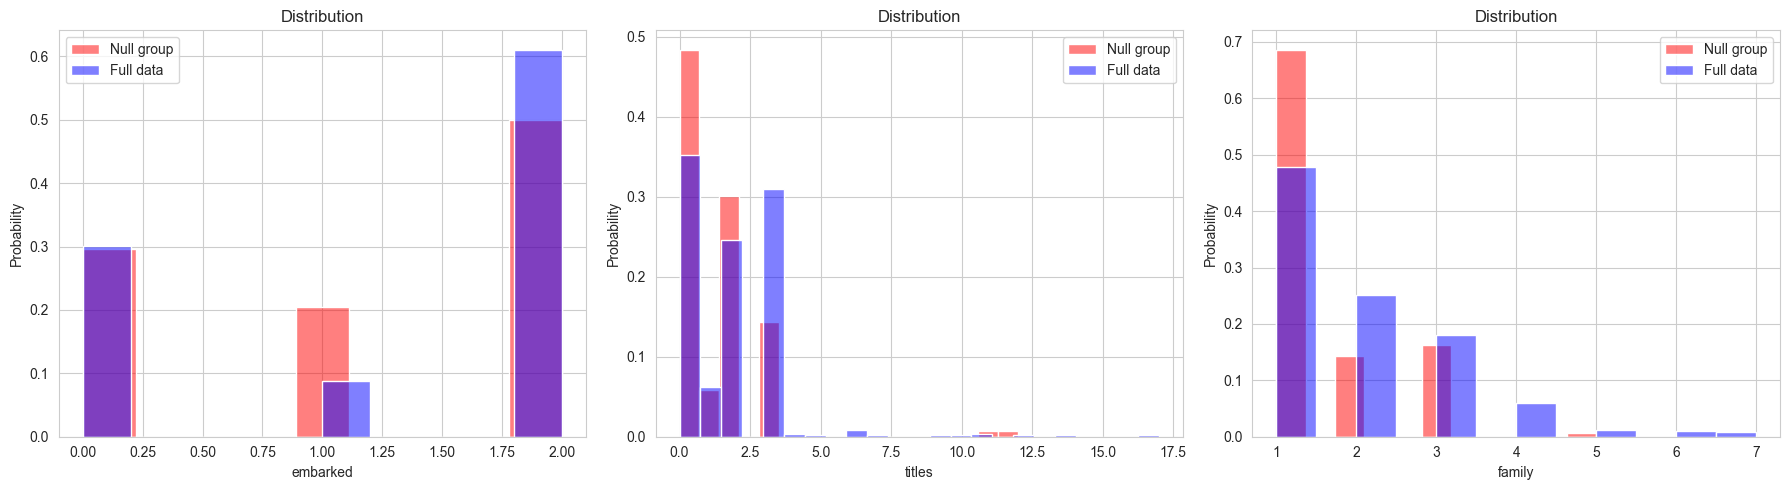

In [22]:
plot_null_vs_full(
    (df_live.loc[df_live['home.dest'].isna(), 'pclass'], df_live['pclass']),
    (df_live.loc[df_live['home.dest'].isna(), 'sibsp'], df_live['sibsp']),
    (df_live.loc[df_live['home.dest'].isna(), 'parch'], df_live['parch'])
)
plot_null_vs_full(
    (df_live.loc[df_live['home.dest'].isna(), 'embarked'], df_live['embarked']),
    (df_live.loc[df_live['home.dest'].isna(), 'titles'], df_live['titles']),
    (df_live.loc[df_live['home.dest'].isna(), 'family'], df_live['family'])
)

## Zmarli
### Grupa wieku

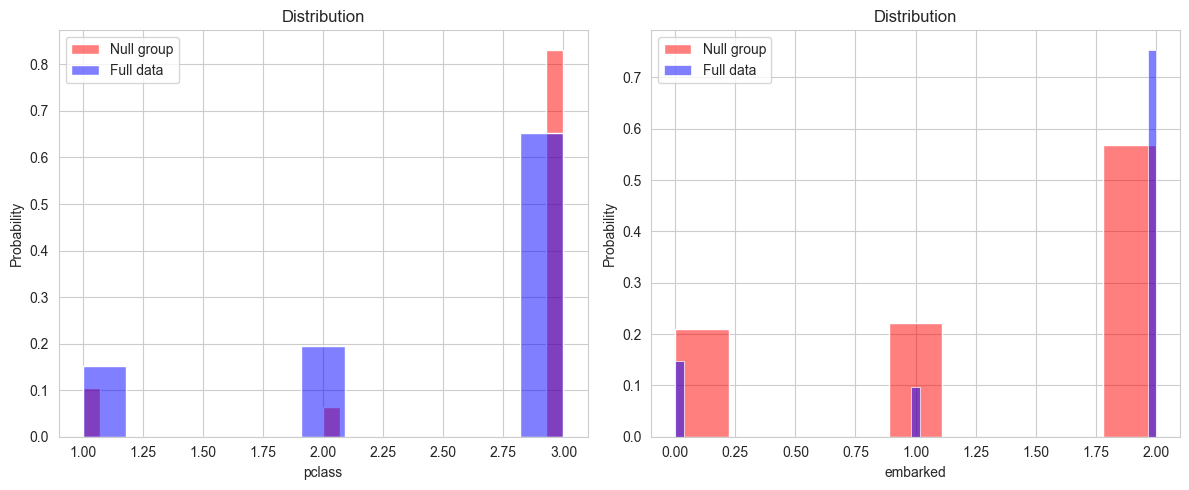

In [23]:
plot_null_vs_full(
    (df_dead.loc[df_dead['age_group'].isna(), 'pclass'], df_dead['pclass']),
    (df_dead.loc[df_dead['age_group'].isna(), 'embarked'], df_dead['embarked']),
)

### Wiek

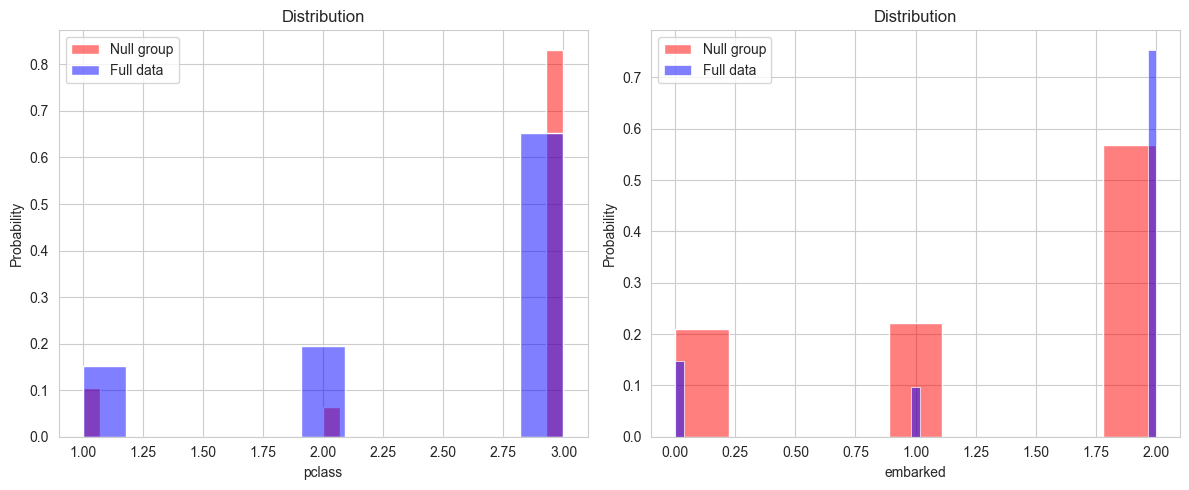

In [24]:
plot_null_vs_full(
    (df_dead.loc[df_dead['age'].isna(), 'pclass'], df_dead['pclass']),
    (df_dead.loc[df_dead['age'].isna(), 'embarked'], df_dead['embarked']),
)

### Kabina

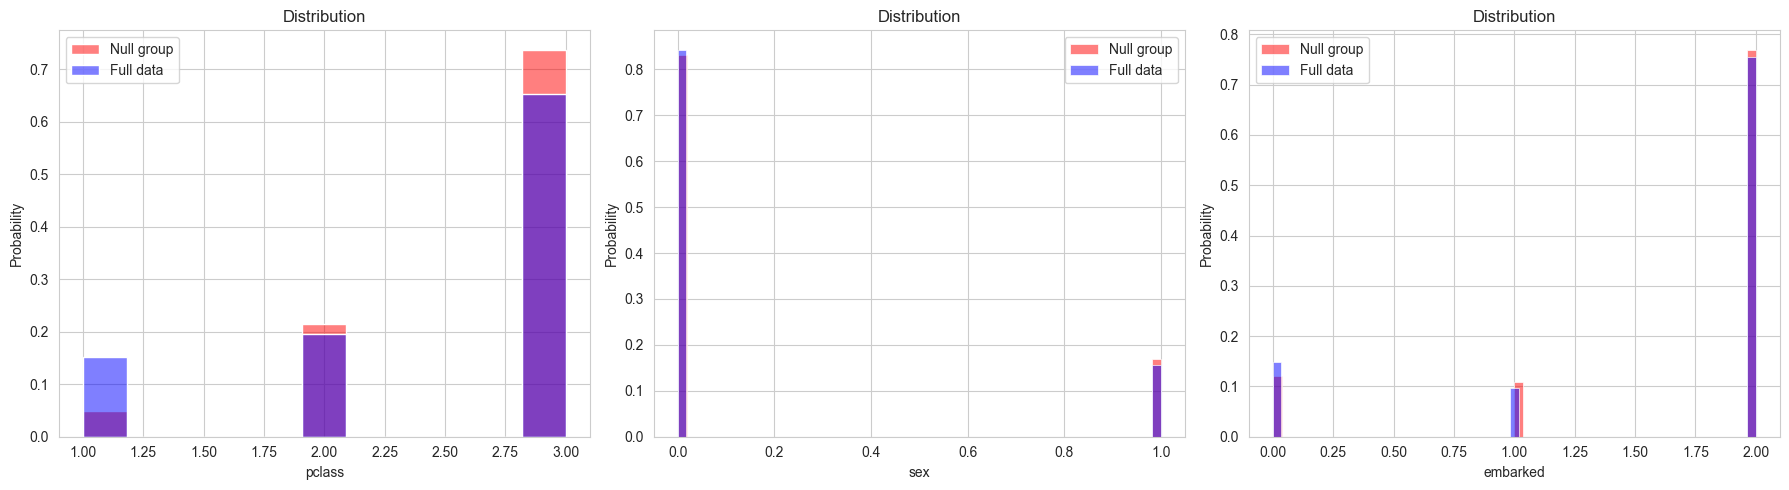

In [25]:
plot_null_vs_full(
    (df_dead.loc[df_dead['cabin'].isna(), 'pclass'], df_dead['pclass']),
    (df_dead.loc[df_dead['cabin'].isna(), 'sex'], df_dead['sex']),
    (df_dead.loc[df_dead['cabin'].isna(), 'embarked'], df_dead['embarked']),
)

### Miejsce Zamieszkania

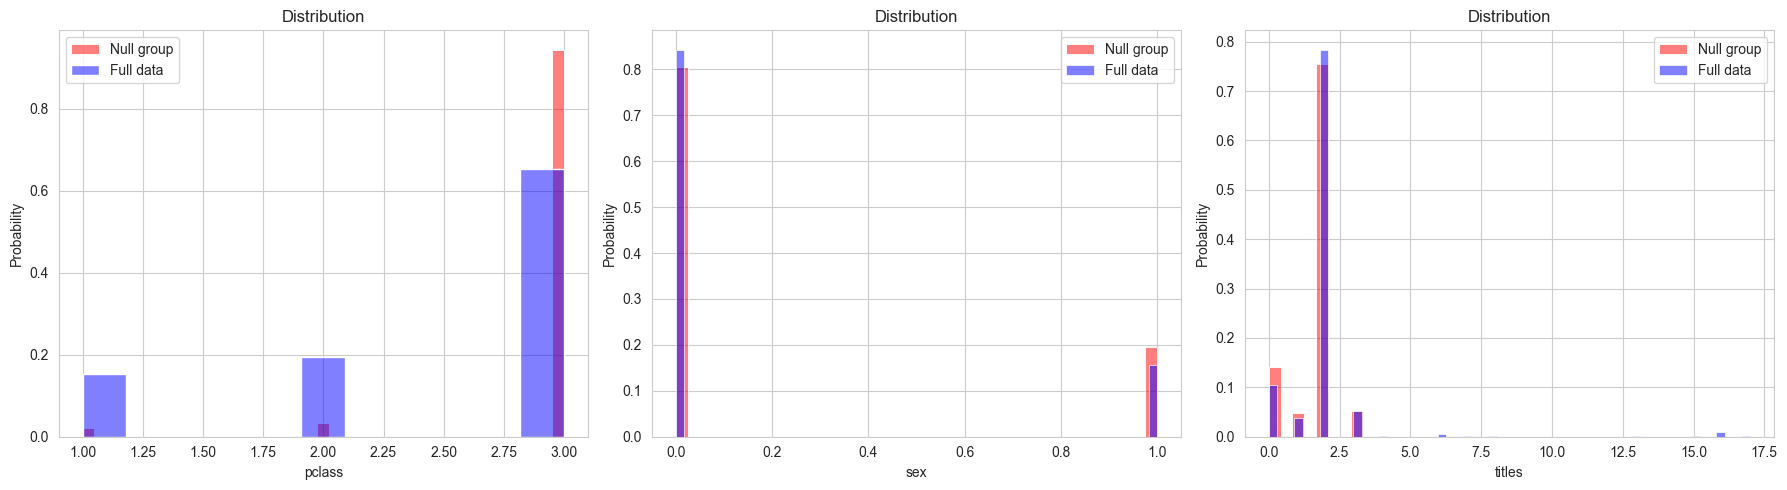

In [26]:
plot_null_vs_full(
    (df_dead.loc[df_dead['home.dest'].isna(), 'pclass'], df_dead['pclass']),
    (df_dead.loc[df_dead['home.dest'].isna(), 'sex'], df_dead['sex']),
    (df_dead.loc[df_dead['home.dest'].isna(), 'titles'], df_dead['titles']),
)

# Krok 7: Typy braków danych – podsumowanie

In [29]:
pd.DataFrame({
    "Kolumna": [
        "fare", "embarked", "body (zmarli)", "boat (zmarli)",
        "age / age_group (ocaleni)", "cabin (ocaleni)", "home.dest (ocaleni)",
        "age / age_group (zmarli)", "cabin (zmarli)", "home.dest (zmarli)"
    ],
    "Typ braku": [
        "MCAR", "MCAR", "MCAR", "MAR",
        "MNAR", "MNAR", "MNAR",
        "MNAR", "MNAR", "MNAR"
    ],
    "Uzasadnienie": [
        "Tylko 1 brakująca wartość",
        "Tylko 2 brakujące wartości",
        "Wiadomo, że większość ciał nigdy nie odnaleziono",
        "Niewiele rekordów; wiedza ekspercka sugeruje inne przyczyny braków, np. wychłodzenie",
        "Największe prawdopodobieństwo braków wśród osób podróżujących 3 klasą, bez rodziny, wchodzących na pokład w porcie Q",
        "Zazwyczaj niezamężne kobiety (Miss), bez rodzeństwa, podróżujące 3 klasą, wchodzące w porcie C",
        "Brak danych częściej u osób podróżujących 3 klasą, Miss lub Mr, bez rodziny, wchodzących w porcie Q",
        "Brak danych prawdopodobnie dotyczy osób podróżujących 3 klasą, wchodzących w porcie Q",
        "Najczęściej kobiety podróżujące 3 klasą wchodzące w porcie Q",
        "Najczęściej brak danych dla Miss podróżujących 3 klasą"
    ]
})

,Kolumna,Typ braku,Uzasadnienie
0,fare,MCAR,Tylko 1 brakująca wartość
1,embarked,MCAR,Tylko 2 brakujące wartości
2,body (zmarli),MCAR,"Wiadomo, że większość ciał nigdy nie odnaleziono"
3,boat (zmarli),MAR,Niewiele rekordów; wiedza ekspercka sugeruje i...
4,age / age_group (ocaleni),MNAR,Największe prawdopodobieństwo braków wśród osó...
5,cabin (ocaleni),MNAR,"Zazwyczaj niezamężne kobiety (Miss), bez rodze..."
6,home.dest (ocaleni),MNAR,Brak danych częściej u osób podróżujących 3 kl...
7,age / age_group (zmarli),MNAR,Brak danych prawdopodobnie dotyczy osób podróż...
8,cabin (zmarli),MNAR,Najczęściej kobiety podróżujące 3 klasą wchodz...
9,home.dest (zmarli),MNAR,Najczęściej brak danych dla Miss podróżujących...


# Krok 8: Strategie postępowania z brakującymi wartościami

## Opuścić rekordy
- Cena biletu `fare` – pojedyncze braki.  
- Port wypłynięcia `embarked` – pojedyncze braki.  

## Wymodelować
- Wiek `age`.  
- Grupa wieku `age_group`.  
- Kabina `cabin`.  
- Miejsce zamieszkania `home.dest` – jeśli ograniczymy dane tylko do stanu/kraju; warto rozważyć, czy będą potrzebne w dalszym modelowaniu.  

## Zamienić na zmienną jakościową
- Numer ciała `body`: 0 – przeżył, 1 – znamy numer ciała, 2 – nie znamy numeru ciała.  
- Szalupa `boat`: 0 – nie znamy szalupy, 1 – znamy szalupę.  
